In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
sys.path.append(r'C:\Users\acostamendoza\Documents\Code\Grid-orientation-project\src')
import os
from GridMetrics import GridScorer, circle_mask, get_even_odd_times, GridParameters, create_new_result_dir, load_grid_metrics_from_pickle
import json
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'GridMetrics'

In [23]:
fig_directory = r'C:\Users\acostamendoza\Box\grid-cell-project\figure_3'

rat = 'r1'
mod = '2'

G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)

with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
    cell_trial_dict = json.load(f)

Directory C:\Users\acostamendoza\Documents\Code\Grid-orientation-project\results\r12 already exists


# Method computing odds and evens

1. **Selection of time chunks** : We divide the recording into chunks according to how many seconds we want the chunks to be. In this recording, the sampling rate of spatial variables (x,y) and spikes is 10ms, so if we want 10s chunks we will be having chunks of length 10*100 = 1000 bins
2. **Assignation of the number of odds and evens chunks** : We compute, given the size of the chunks, how many odds and even the session will have (the recording is 120 minutes, so 10s chunks will end up being 360 odd chunks and 360 even chunks). Then, we randomly assign to each chunk an odd or even identity
3. **Computation of odd and even SAC**: For a given trial, the odd times are extracted so that we can have all the spatial coordinates and spikes given those times. With those, we recompute the spatial maps and SAC to extract orientation and spacing.

We do this method 100 times for each cell, giving us the odd and evens spacing, orientation and grid score. If **any** of the odds and even splits of any given trial fails to meet orientation and spacing criteria set before, then the whole cell is not considered for further analysis.

# Figure 2A: Orientation and spacing distribution

C:\Users\acostamendoza\Documents\Code\Grid-orientation-project\src\GridMetrics.py:225: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


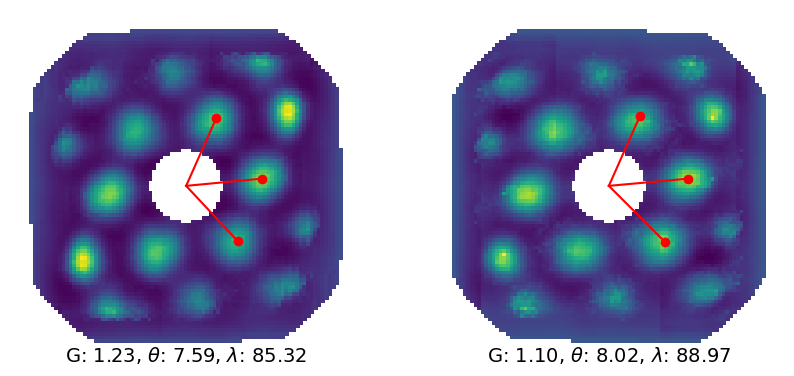

In [3]:
cell = 65
valid_times = get_even_odd_times(length_of_recording = len(G.x), seconds_per_bin = 1000)

sac_odd, sac_even = G.get_odd_and_even_sacs(cell, valid_times)
G.show_odd_even_orientation_and_spacing(sac_odd, sac_even)

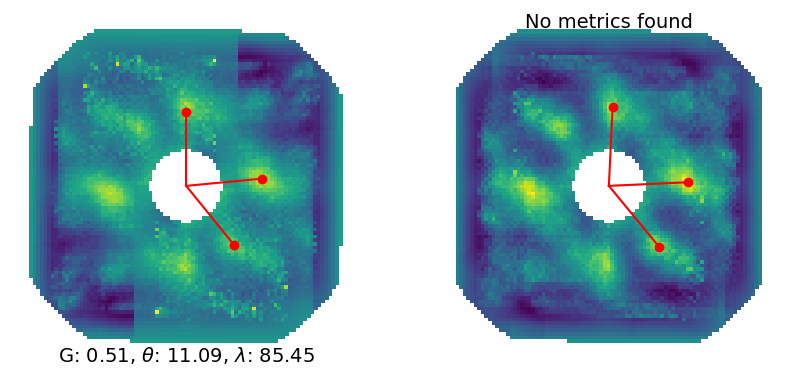

In [4]:
cell = 3
valid_times = get_even_odd_times(length_of_recording = len(G.x), seconds_per_bin = 0.5)
sac_odd, sac_even = G.get_odd_and_even_sacs(cell, valid_times)
G.show_odd_even_orientation_and_spacing(sac_odd, sac_even)

# Figure 2B-middle: Odds vs evens distribution

In [3]:
def get_odds_even_distribution(cell_trial_dict):
    
    accepted = []
    
    for cell in cell_trial_dict:
        none_trials = 0
        for trial in cell_trial_dict[cell]:
            if cell_trial_dict[cell][trial]['spacing_odd'] is None:
                none_trials += 1
            elif cell_trial_dict[cell][trial]['spacing_even'] is None:
                none_trials += 1
                
        if none_trials <= 5:
            accepted.append(cell)

    delta_orientation_single_cell = []
    delta_orientation_two_cells = []
    delta_spacing_single_cell = []
    delta_spacing_two_cells = []
    
    for cell in accepted:
        for trial in cell_trial_dict[cell]:
            
            if (cell_trial_dict[cell][trial]['spacing_odd'] is not None) and (cell_trial_dict[cell][trial]['spacing_even'] is not None):
                
                delta_orientation_single_cell.append(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[cell][trial]['orientation_odd'])
                second_cell = random.choice(list(accepted))
                while (cell_trial_dict[second_cell][trial]['spacing_odd'] is None) or (cell_trial_dict[second_cell][trial]['spacing_even'] is None):
                    second_cell = random.choice(list(accepted))
                
                delta_orientation_two_cells.append(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[second_cell][trial]['orientation_odd'])
                delta_spacing_single_cell.append(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[cell][trial]['spacing_odd'])
                delta_spacing_two_cells.append(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[second_cell][trial]['spacing_odd'])
    
    return delta_orientation_single_cell, delta_orientation_two_cells, delta_spacing_single_cell, delta_spacing_two_cells

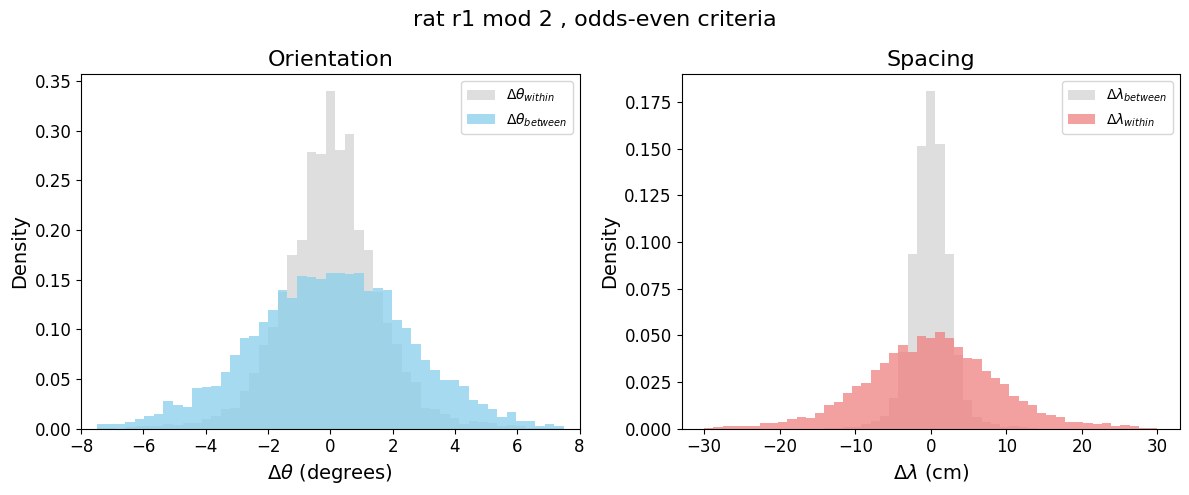

Orientation var within: 1.5689551199263798
Orientation var between: 2.575164699828408
Spacing var within: 2.5696407422344834
Spacing var between: 8.873219682004708
p value levene test: 0.0
statistic levene test: 1717.5157579621975
p value levene test: 0.0
statistic levene test: 5863.484059009106


In [7]:
delta_orientation_within, delta_orientation_between, delta_spacing_within, delta_spacing_between = get_odds_even_distribution(cell_trial_dict)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('rat ' + rat + ' mod ' + mod +  ' , odds-even criteria', fontsize = 16)

# Plot histogram for the original data
axes[0].hist(delta_orientation_within, color = 'lightgray', bins=np.linspace(-7.5, 7.5, 50), density = True, alpha = 0.75, label = r'$\Delta\theta_{within}$')
axes[0].hist(delta_orientation_between, color = 'skyblue', bins=np.linspace(-7.5, 7.5, 50), density = True, alpha = 0.75, label = r'$\Delta\theta_{between}$')
axes[0].set_xlabel(r'$\Delta\theta$ (degrees)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(-8, 8)
axes[0].set_title('Orientation', fontsize = 16)

# Plot histogram for the filtered data (excluding None entries)
axes[1].hist(delta_spacing_within, color = 'lightgray', bins=np.linspace(-30, 30, 50), density = True, alpha = 0.75)
axes[1].hist(delta_spacing_between, color = 'lightcoral', bins=np.linspace(-30, 30, 50), density = True, alpha = 0.75)
axes[1].set_xlabel(r'$\Delta\lambda$ (cm)')
axes[1].set_ylabel('Density')
axes[1].legend([r'$\Delta\lambda_{between}$', r'$\Delta\lambda_{within}$'])
axes[1].set_title('Spacing', fontsize = 16)

# set all labels to fontsize 14
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    
plt.savefig(fig_directory + '/' + rat + mod + '/A_odds_even_distribution.svg', dpi=600)

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

# print the std of the distributions
print('Orientation var within: ' + str(np.std(delta_orientation_within)))
print('Orientation var between: ' + str(np.std(delta_orientation_between)))
print('Spacing var within: ' + str(np.std(delta_spacing_within)))
print('Spacing var between: ' + str(np.std(delta_spacing_between)))

# do a levene test to check if the differences in variance are significant
from scipy.stats import levene
# from scipy.stats import ks_2samp

statistic, pvalue = levene(delta_orientation_within, delta_orientation_between)
print('p value levene test: ' + str(pvalue))
print('statistic levene test: ' + str(statistic))

statistic, pvalue = levene(delta_spacing_within, delta_spacing_between)
print('p value levene test: ' + str(pvalue))
print('statistic levene test: ' + str(statistic))

Orientation var within: 1.5689551199263798
Orientation var between: 2.592428950341561
Spacing var within: 2.5696407422344834
Spacing var between: 8.765868345427288
Orientation levene test p = 0.0
Spacing levene test p = 0.0


# 2C: Scatter plot of every cell

In [19]:
def get_delta_mean_differences(cell_trial_dict):
    
    accepted = []
    
    for cell in cell_trial_dict:
        none_trials = 0
        for trial in cell_trial_dict[cell]:
            if cell_trial_dict[cell][trial]['spacing_odd'] is None:
                none_trials += 1
            elif cell_trial_dict[cell][trial]['spacing_even'] is None:
                none_trials += 1
                
        if none_trials <= 5:
            accepted.append(cell)
    
    delta_orientation_within_mean = []
    delta_orientation_between_mean = []
    delta_spacing_within_mean = []
    delta_spacing_between_mean = []
    
    for cell in accepted:
        delta_orientation_single_cell = []
        delta_orientation_two_cells = []
        delta_spacing_single_cell = []
        delta_spacing_two_cells = []
        for trial in cell_trial_dict[cell]:
            
            if (cell_trial_dict[cell][trial]['spacing_odd'] is not None) and (cell_trial_dict[cell][trial]['spacing_even'] is not None):
            
                delta_orientation_single_cell.append(abs(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[cell][trial]['orientation_odd']))
                second_cell = random.choice(list(accepted))
                while (cell_trial_dict[second_cell][trial]['spacing_odd'] is None) or (cell_trial_dict[second_cell][trial]['spacing_even'] is None):
                    second_cell = random.choice(list(accepted))
                delta_orientation_two_cells.append(abs(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[second_cell][trial]['orientation_odd']))
                delta_spacing_single_cell.append(abs(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[cell][trial]['spacing_odd']))
                delta_spacing_two_cells.append(abs(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[second_cell][trial]['spacing_odd']))
            
        delta_orientation_within_mean.append(np.mean(delta_orientation_single_cell))
        delta_orientation_between_mean.append(np.mean(delta_orientation_two_cells))
        delta_spacing_within_mean.append(np.mean(delta_spacing_single_cell))
        delta_spacing_between_mean.append(np.mean(delta_spacing_two_cells))
    
    # convert all four variables to arrays
    delta_orientation_within_mean = np.array(delta_orientation_within_mean)
    delta_orientation_between_mean = np.array(delta_orientation_between_mean)
    delta_spacing_within_mean = np.array(delta_spacing_within_mean)
    delta_spacing_between_mean = np.array(delta_spacing_between_mean)
    
    return delta_orientation_within_mean, delta_orientation_between_mean, delta_spacing_within_mean, delta_spacing_between_mean

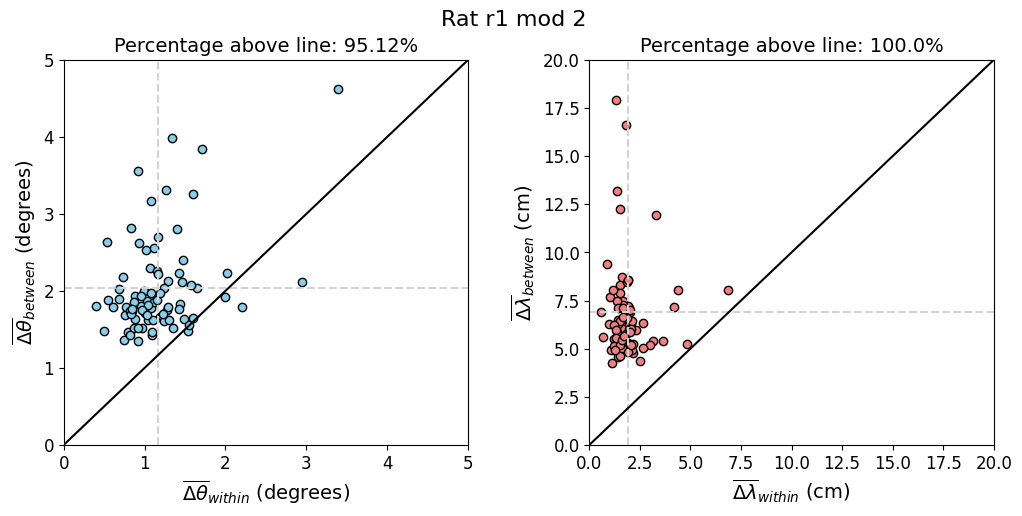

In [24]:
 # Create a figure with two subplots
delta_orientation_within_mean, delta_orientation_between_mean, delta_spacing_within_mean, delta_spacing_between_mean = get_delta_mean_differences(cell_trial_dict)

orientation_above = np.sum(delta_orientation_between_mean > delta_orientation_within_mean)/ len(delta_orientation_within_mean)
spacing_above = np.sum(delta_spacing_between_mean > delta_spacing_within_mean)/ len(delta_spacing_within_mean)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)
plt.suptitle('Rat ' +  rat + ' mod ' + mod , fontsize = 16)

# plot scatter plot of orientation
axes[0].scatter(delta_orientation_within_mean, delta_orientation_between_mean, color='skyblue', edgecolor='black')
axes[0].set_xlabel(r'$\overline{\Delta\theta}_{within}$ (degrees)')
axes[0].set_ylabel(r'$\overline{\Delta\theta}_{between}$ (degrees)')
axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, 5)
# plot a vertical dash line with the mean of delta_orientation_within_mean
axes[0].axvline(x=delta_orientation_within_mean.mean(), color='lightgray', linestyle='--')
# plot a horizontal dash line with the mean of delta_orientation_between_mean
axes[0].axhline(y=delta_orientation_between_mean.mean(), color='lightgray', linestyle='--')
# plot a diagonal line
axes[0].plot([0, 5], [0, 5], color='black')
axes[0].set_title('Percentage above line: ' + str(round(orientation_above*100, 2)) + '%', fontsize = 14)

# plot scatter plot of spacing
axes[1].scatter(delta_spacing_within_mean, delta_spacing_between_mean, color='lightcoral', edgecolor='black')
axes[1].set_xlabel(r'$\overline{\Delta\lambda}_{within}$ (cm)')
axes[1].set_ylabel(r'$\overline{\Delta\lambda}_{between}$ (cm)')
axes[1].set_xlim(0, 20)
axes[1].set_ylim(0, 20)
# plot a vertical dash line with the mean of delta_spacing_within_mean
axes[1].axvline(x=delta_spacing_within_mean.mean(), color='lightgray', linestyle='--')
# plot a horizontal dash line with the mean of delta_spacing_between_mean
axes[1].axhline(y=delta_spacing_between_mean.mean(), color='lightgray', linestyle='--')
# plot a diagonal line
axes[1].plot([0, 20], [0, 20], color='black')
axes[1].set_title('Percentage above line: ' + str(round(spacing_above*100, 2)) + '%', fontsize = 14)

# set all labels to fontsize 14
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    
plt.savefig(fig_directory + '/' + rat + mod + '/' + 'B_scatter_plot_differences.svg', dpi=1200)

In [25]:
# print mean values
print('Mean delta orientation within: ' + str(delta_orientation_within_mean.mean()))
print('Mean delta orientation between: ' + str(delta_orientation_between_mean.mean()))
print('Mean delta spacing within: ' + str(delta_spacing_within_mean.mean()))
print('Mean delta spacing between: ' + str(delta_spacing_between_mean.mean()))


Mean delta orientation within: 1.1673970557373372
Mean delta orientation between: 2.0345275948737642
Mean delta spacing within: 1.8966165865303213
Mean delta spacing between: 6.888301275063384


In [18]:
# Run wilcoxon signed-rank test to see if the differences are significant
from scipy.stats import wilcoxon
statistic, pvalue = wilcoxon(delta_orientation_between_mean, delta_orientation_within_mean)
print('p value orientation: ' + str(pvalue))
print('statistic orientation: ' + str(statistic))

statistic, pvalue = wilcoxon(delta_spacing_between_mean, delta_spacing_within_mean)
print('p value spacing: ' + str(pvalue))
print('statistic spacing: ' + str(statistic))
print(statistic)

p value orientation: 4.266161900665611e-15
statistic orientation: 60.0
p value spacing: 5.460181414946209e-16
statistic spacing: 0.0
0.0


# Figure 2C: variance vs grid score

In [16]:
G.grid_scores[cell]

TypeError: list indices must be integers or slices, not str

In [19]:
delta_orientation_single_cell_mean = []
delta_orientation_two_cells_mean = []
delta_spacing_single_cell_mean = []
delta_spacing_two_cells_mean = []
grid_score = []
    
for cell in cell_trial_dict:
    grid_score.append(G.grid_scores[int(cell)])
    
    delta_orientation_single_cell = []
    delta_orientation_two_cells = []
    delta_spacing_single_cell = []
    delta_spacing_two_cells = []
    for trial in cell_trial_dict[cell]:
        delta_orientation_single_cell.append(abs(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[cell][trial]['orientation_odd']))
        second_cell = random.choice(list(cell_trial_dict.keys()))
        delta_orientation_two_cells.append(abs(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[second_cell][trial]['orientation_odd']))
        delta_spacing_single_cell.append(abs(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[cell][trial]['spacing_odd']))
        delta_spacing_two_cells.append(abs(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[second_cell][trial]['spacing_odd']))
        
    delta_orientation_single_cell_mean.append(np.mean(delta_orientation_single_cell))
    delta_orientation_two_cells_mean.append(np.mean(delta_orientation_two_cells))
    delta_spacing_single_cell_mean.append(np.mean(delta_spacing_single_cell))
    delta_spacing_two_cells_mean.append(np.mean(delta_spacing_two_cells))
    
# convert all four variables to arrays
delta_orientation_single_cell_mean = np.array(delta_orientation_single_cell_mean)
delta_orientation_two_cells_mean = np.array(delta_orientation_two_cells_mean)
delta_spacing_single_cell_mean = np.array(delta_spacing_single_cell_mean)
delta_spacing_two_cells_mean = np.array(delta_spacing_two_cells_mean)
grid_score = np.array(grid_score)

In [35]:
# plot the std deviation in orienation and spacing vs the grid score of every binb
bins = np.linspace(0.6, 1.2, 7)
digitized = np.digitize(grid_score, bins)

bin_within_orientation = []
bin_between_orientation = []

bin_within_spacing = []
bin_between_spacing = []

for i in range(0, len(bins)):
    
    bin_within_orientation.append(delta_orientation_single_cell_mean[digitized == i].mean())
    bin_between_orientation.append(delta_orientation_two_cells_mean[digitized == i].mean())
    
    bin_within_spacing.append(delta_spacing_single_cell_mean[digitized == i].mean())
    bin_between_spacing.append(delta_spacing_two_cells_mean[digitized == i].mean())
    

C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\2188860673.py:13: RuntimeWarning: Mean of empty slice.
  bin_within_orientation.append(delta_orientation_single_cell_mean[digitized == i].mean())
C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\2188860673.py:14: RuntimeWarning: Mean of empty slice.
  bin_between_orientation.append(delta_orientation_two_cells_mean[digitized == i].mean())
C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\2188860673.py:16: RuntimeWarning: Mean of empty slice.
  bin_within_spacing.append(delta_spacing_single_cell_mean[digitized == i].mean())
C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\2188860673.py:17: RuntimeWarning: Mean of empty slice.
  bin_between_spacing.append(delta_spacing_two_cells_mean[digitized == i].mean())


In [98]:
len(grid_score)

64

C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\1968672543.py:18: RuntimeWarning: Mean of empty slice.
  bin_within_orientation.append(delta_orientation_single_cell_mean[digitized == i].mean())
C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\1968672543.py:19: RuntimeWarning: Mean of empty slice.
  bin_between_orientation.append(delta_orientation_two_cells_mean[digitized == i].mean())
C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\1968672543.py:21: RuntimeWarning: Mean of empty slice.
  bin_within_spacing.append(100 * delta_spacing_single_cell_mean[digitized == i].mean())
C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_12528\1968672543.py:22: RuntimeWarning: Mean of empty slice.
  bin_between_spacing.append(100 * delta_spacing_two_cells_mean[digitized == i].mean())


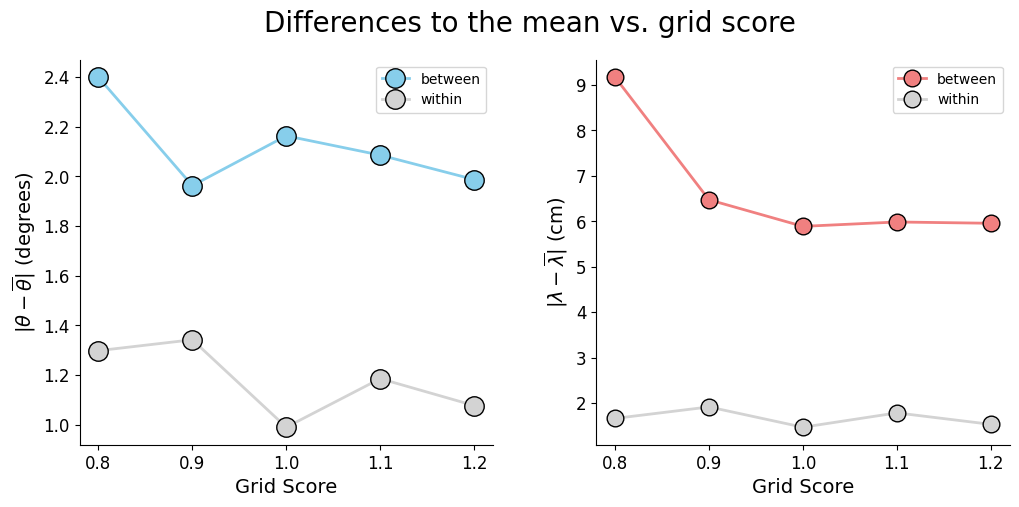

In [97]:
# plot the std deviation in orienation and spacing vs the grid score of every binb
bins = np.linspace(0.6, 1.2, 7)
digitized = np.digitize(grid_score, bins)

# count how many cells in each bin
bin_counts = np.zeros_like(bins)
bin_delta_orientation = np.zeros_like(bins)
bin_delta_spacing = np.zeros_like(bins)

bin_within_orientation = []
bin_between_orientation = []

bin_within_spacing = []
bin_between_spacing = []

for i in range(0, len(bins)):
    
    bin_within_orientation.append(delta_orientation_single_cell_mean[digitized == i].mean())
    bin_between_orientation.append(delta_orientation_two_cells_mean[digitized == i].mean())
    
    bin_within_spacing.append(100 * delta_spacing_single_cell_mean[digitized == i].mean())
    bin_between_spacing.append(100 * delta_spacing_two_cells_mean[digitized == i].mean())
    
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# make some space between subplots
fig.subplots_adjust(wspace=0.25)
# set fig title
fig.suptitle('Differences to the mean vs. grid score', fontsize=20)

axes[0].plot(bins, bin_between_orientation, label = 'between', color='skyblue', marker='o', markeredgecolor = 'black', linewidth=2, markersize=14)
axes[0].plot(bins, bin_within_orientation, label = 'within', color='lightgray', marker='o', markeredgecolor = 'black', linewidth=2, markersize=14)
axes[0].set_xlabel('Grid Score')
axes[0].set_ylabel(r'|$\theta - \overline{\theta} $| (degrees)')
axes[0].legend()

axes[1].plot(bins, bin_between_spacing, label = 'between', markeredgecolor = 'black',color='lightcoral', marker='o', linewidth=2, markersize=12)
axes[1].plot(bins, np.array(bin_within_spacing), label = 'within', markeredgecolor = 'black',color='lightgray', marker='o', linewidth=2, markersize=12)
axes[1].set_xlabel('Grid Score')
axes[1].set_ylabel(r'|$\lambda - \overline{\lambda} $| (cm)')
axes[1].legend()

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    # remove top and right splines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.savefig(fig_directory + '/' + 'C_variance_vs_grid_score.png', dpi=1200)

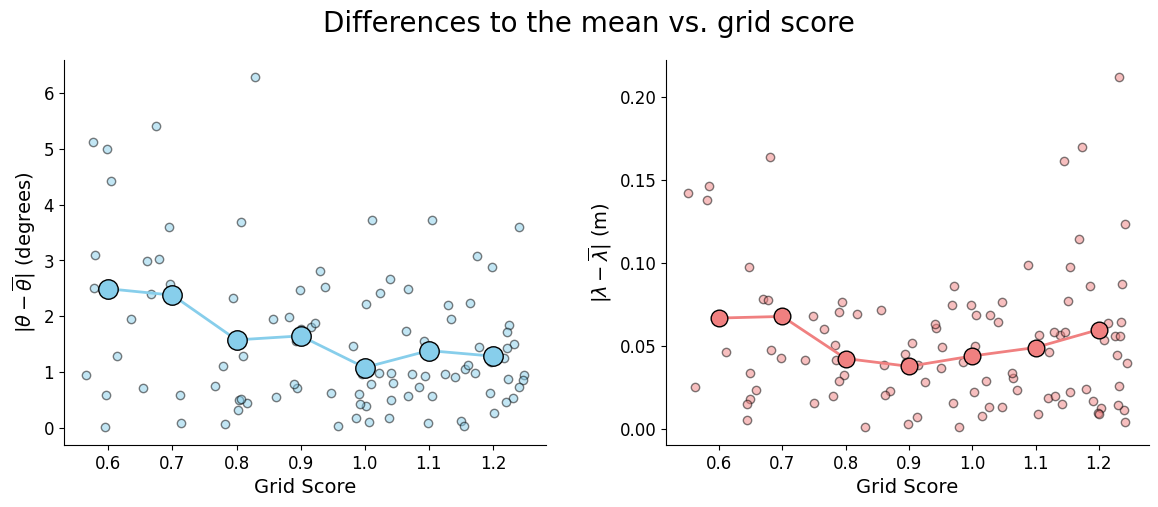

In [12]:
# plot the std deviation in orienation and spacing vs the grid score of every binb
bins = np.linspace(0.6, 1.2, 7)
digitized = np.digitize(filtered_score, bins)

mean_orientation = np.mean(filtered_orientation)
mean_spacing = np.mean(filtered_spacing)
# count how many cells in each bin
bin_counts = np.zeros_like(bins)
bin_delta_orientation = np.zeros_like(bins)
bin_delta_spacing = np.zeros_like(bins)

bin_orientations = []
bin_spacings = []
bin_delta_orientations = []
bin_delta_spacings = []
for i in range(1, len(bins)+1):
    bin_orientations.append(np.array(filtered_orientation)[digitized == i])
    bin_spacings.append(np.array(filtered_spacing)[digitized == i])

    bin_counts[i-1] = len(bin_orientations[-1])
    bin_delta_orientations.append(np.abs(bin_orientations[-1] - mean_orientation))
    bin_delta_spacings.append(np.abs(bin_spacings[-1] - mean_spacing))
    bin_delta_spacing[i-1] = np.abs(bin_spacings[-1] - mean_spacing).mean()
    bin_delta_orientation[i-1] = np.abs(bin_orientations[-1] - mean_orientation).mean()

# Create a figure with two subplots, one for orientation and one for spacing with x axis being grid score in a scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# make some space between subplots
fig.subplots_adjust(wspace=0.25)
# set fig title
fig.suptitle('Differences to the mean vs. grid score', fontsize=20)

axes[0].plot(bins, bin_delta_orientation, color='skyblue', marker='o', markeredgecolor = 'black', linewidth=2, markersize=14)

for i in range(len(bins)):
    for x in bin_delta_orientations[i]:
        jitter = random.uniform(-0.05, 0.05)
        axes[0].scatter(bins[i] + jitter, x, color='skyblue', edgecolor='black', alpha=0.5)
axes[0].set_xlabel('Grid Score')
axes[0].set_ylabel(r'|$\theta - \overline{\theta} $| (degrees)')

axes[1].plot(bins, bin_delta_spacing, markeredgecolor = 'black',color='lightcoral', marker='o', linewidth=2, markersize=12)
for i in range(len(bins)):
    for x in bin_delta_spacings[i]:
        jitter = random.uniform(-0.05, 0.05)
        axes[1].scatter(bins[i] + jitter, x, color='lightcoral', edgecolor='black', alpha=0.5)
axes[1].set_xlabel('Grid Score')
axes[1].set_ylabel(r'|$\lambda - \overline{\lambda} $| (m)')


for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    # remove top and right splines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# plt.savefig(session_results_directory + '/' + rat + mod +  '_variance_vs_grid_score.png', dpi=300)

# Reliability of cells

To see how reliable a cell we can look at the average delta between odd and even and plot it against the grid score

In [107]:
mean_delta_orientation = []
mean_delta_spacing = []
grid_score = []

for cell in cell_trial_dict:
    grid_score.append(G.grid_scores[int(cell)])
    delta_orientation = []
    delta_spacing = []
    for trial in cell_trial_dict[cell]:
        delta_orientation.append(cell_trial_dict[cell][trial]['orientation_even'] - cell_trial_dict[cell][trial]['orientation_odd'])
        delta_spacing.append(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[cell][trial]['spacing_odd'])
    mean_delta_orientation.append(np.mean(delta_orientation))
    mean_delta_spacing.append(np.mean(delta_spacing))
    
mean_delta_spacing = np.array(mean_delta_spacing)
mean_delta_orientation = np.array(mean_delta_orientation)
grid_score = np.array(grid_score)

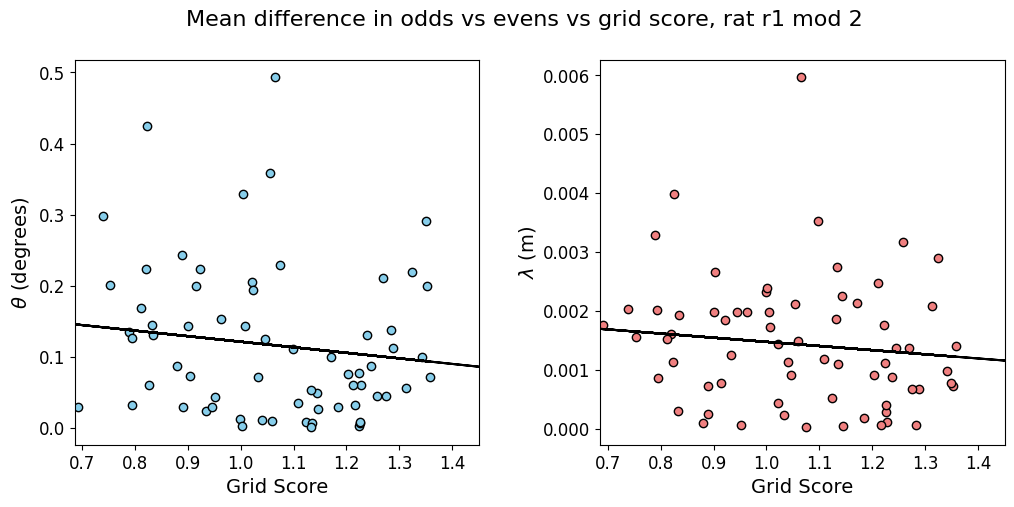

In [109]:
# Create a figure with two subplots, one for orientation and one for spacing with x axis being grid score in a scatter plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# make the subplots space out a bit
plt.subplots_adjust(wspace=0.3)
plt.suptitle('Mean difference in odds vs evens vs grid score, rat ' + rat + ' mod ' + mod, fontsize = 16)

axes[0].scatter(grid_score, abs(mean_delta_orientation), color='skyblue', edgecolor='black')
axes[0].set_xlabel('Grid Score')
axes[0].set_ylabel(r'$\theta$ (degrees)')
axes[0].set_xlim(np.percentile(grid_score, 1), np.percentile(grid_score, 99))

m, b = np.polyfit(grid_score, abs(mean_delta_orientation), 1)
axes[0].plot(grid_score, m*grid_score + b, color='black')

axes[1].scatter(grid_score, abs(np.array(mean_delta_spacing)), color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Grid Score')
axes[1].set_ylabel(r'$\lambda$ (m)')
axes[1].set_xlim(np.percentile(grid_score, 1), np.percentile(grid_score, 99))

m, b = np.polyfit(grid_score, abs(mean_delta_spacing), 1)
axes[1].plot(grid_score, m*grid_score + b, color='black')
# set all labels to fontsize 14
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

plt.savefig(session_results_directory + '/' + rat + mod +  '2_mean_difference_odds_evens', dpi=300)